In [57]:
path = "COVID-Dialogue-Dataset-English.txt"
f = open(path,encoding="UTF-8")
l1 = f.read()
l2 = l1.split("id=")
p2d = []
d2p = []
for item in l2:
    if len(item) != 0:
        temp = item.split("Dialogue\nPatient:")
        if len(temp) > 1:
            item2 = temp[1]
            item3 = item2.split("Patient:")
            l = []
            if len(item3) != 0:
                for item4 in item3:
                    item5 = item4.split("Doctor:")
                    l += item5
            for i in range(1, len(l), 2):
                p2d.append((l[i - 1].strip("\n"), l[i].strip("\n")))
                if i + 1 < len(l):
                    d2p.append((l[i].strip("\n"), l[i + 1].strip("\n")))
data = p2d + d2p
data[0]

('Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help.',
 'Hello, I understand your concern. I just have a few more questions.\nDoes your cough has phlegm? Any other symptoms like difficulty breathing? Any other medical condition such as asthma, hypertension? Are you a smoker? Alcoholic beverage drinker?')

In [58]:

#nltk.download('stopwords')
def clean_text(tokenized_list, sw, punct, lemmatize=False):
    new_list = []
    for doc in tokenized_list:
        new_list.append([token.lower() for token in doc if token.lower() not in chain(punct, sw)])
        return new_list
# Remove punctuations and stopwords, and lower-case text\n",
sw = stopwords.words('english')
punct = punctuation
#temp_text = clean_text(token_text, sw, punct)
#temp_title = clean_text(token_title, sw, punct)

In [59]:
dictionary = {}

from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain

sw = stopwords.words('english')
punct = punctuation

def clean_data(data):
    for item in data:
        for item2 in item:
            words = word_tokenize(item2)
            for word in words:
                dictionary.setdefault(word,0)
                dictionary[word] += 1
    data2 = []
    for item in data:
        temp = []
        for item2 in item:
            item2 = " ".join([token for token in word_tokenize(item2) if dictionary[token] > 0 and token.lower() not in chain(punct, sw)])
            temp.append(item2)
        temp = tuple(temp)
        data2.append(temp)
    return data2
data2 = clean_data(data)
data2[0]

('Hello doctor get cough last days heavy night times raise temperature feeling tired travel history contact Covid-19 persons four five days drunk lot Benadryl took Paracetamol Doctors shut OP know Please help',
 'Hello understand concern questions cough phlegm symptoms like difficulty breathing medical condition asthma hypertension smoker Alcoholic beverage drinker')

In [60]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [62]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [63]:
def readLangs(lang):
    print("Reading lines...")
    '''
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    '''
    pairs = [(normalizeString(item[0]), normalizeString(item[1])) for item in data2]
    # Reverse pairs, make Lang instances


    lang = Lang(lang)

    return lang, pairs

In [64]:
MAX_LENGTH = 1000

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [65]:
def prepareData(lang):
    lang, pairs = readLangs(lang)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #print(pair)
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs


lang, pairs = prepareData('lang')
print(random.choice(pairs))

Reading lines...
Read 628 sentence pairs
Trimmed to 628 sentence pairs
Counting words...
Counted words:
lang 5282
('traveled headache spite cough week throat getting sore chest feels slightly tight fever', 'virus viral respiratory tract infection absence fever reassuring time fever shortness breath develop re area covid present call md instructions drink adequate fluids gargle warm salt water also recommend using zinc lozenges take acetaminophen')


In [66]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [67]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [68]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [69]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor)

In [70]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [71]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [72]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [73]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [74]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [75]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 10s (- 36m 26s) (50 0%) 5.0889
0m 16s (- 27m 28s) (100 1%) 3.6654
0m 26s (- 28m 29s) (150 1%) 5.0958
0m 32s (- 26m 19s) (200 2%) 4.0895
0m 40s (- 26m 5s) (250 2%) 4.8753
0m 47s (- 25m 32s) (300 3%) 4.9326
0m 55s (- 25m 39s) (350 3%) 5.7255
1m 4s (- 25m 44s) (400 4%) 4.9985
1m 14s (- 26m 22s) (450 4%) 5.6726
1m 21s (- 25m 45s) (500 5%) 5.4888
1m 30s (- 25m 46s) (550 5%) 5.3183
1m 39s (- 25m 58s) (600 6%) 5.4049
1m 47s (- 25m 52s) (650 6%) 4.9827
1m 56s (- 25m 53s) (700 7%) 5.5618
2m 4s (- 25m 31s) (750 7%) 4.5864
2m 10s (- 25m 5s) (800 8%) 4.5715
2m 19s (- 24m 56s) (850 8%) 5.2281
2m 26s (- 24m 37s) (900 9%) 5.1172
2m 35s (- 24m 40s) (950 9%) 5.5799
2m 42s (- 24m 20s) (1000 10%) 4.7767
2m 49s (- 24m 8s) (1050 10%) 5.6481
2m 59s (- 24m 13s) (1100 11%) 5.6808
3m 8s (- 24m 12s) (1150 11%) 5.2945
3m 18s (- 24m 16s) (1200 12%) 5.4602
3m 26s (- 24m 6s) (1250 12%) 5.3109
3m 35s (- 24m 1s) (1300 13%) 5.7788
3m 43s (- 23m 54s) (1350 13%) 5.1921
3m 53s (- 23m 56s) (1400 14%) 5.7180
4m 2s (- 23

<Figure size 432x288 with 0 Axes>

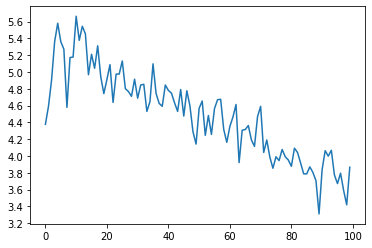

In [76]:
hidden_size = 128
encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=50)

In [77]:
evaluateRandomly(encoder1, attn_decoder1)

> plane march th home ever since self quarantine headaches runny throat days left self quarantine worse symptoms
= brief covid healthtap guidelines https www healthtap .com blog covid care guidelines virtual care guidelines for covid utm campaign covid outreach utm medium email hsmi hsenc p anqtz jlhafqzrxrcncgr mj eqcomm titlnybaqii sh f iyzjpz eivc okn qdpzno utm content utm source hs emaili agree symptoms improving contact provider would like video text chat
< brief covid guidelines https guidelines https www healthtap .com blog covid care guidelines for covid utm guidelines preventing covid guidelines https www .healthtap .com blog post covid care guidelines preventing covid guidelines https www .healthtap .com blog covid care guidelines preventing covid guidelines https www .healthtap .com blog covid care guidelines preventing covid guidelines https www .healthtap .com blog post care guidelines preventing covid guidelines https www .healthtap .com blog post covid care guidelines p

In [78]:
lang.index2word

{0: 'SOS',
 1: 'EOS',
 2: 'hello',
 3: 'doctor',
 4: 'get',
 5: 'cough',
 6: 'last',
 7: 'days',
 8: 'heavy',
 9: 'night',
 10: 'times',
 11: 'raise',
 12: 'temperature',
 13: 'feeling',
 14: 'tired',
 15: 'travel',
 16: 'history',
 17: 'contact',
 18: 'covid',
 19: 'persons',
 20: 'four',
 21: 'five',
 22: 'drunk',
 23: 'lot',
 24: 'benadryl',
 25: 'took',
 26: 'paracetamol',
 27: 'doctors',
 28: 'shut',
 29: 'op',
 30: 'know',
 31: 'please',
 32: 'help',
 33: 'understand',
 34: 'concern',
 35: 'questions',
 36: 'phlegm',
 37: 'symptoms',
 38: 'like',
 39: 'difficulty',
 40: 'breathing',
 41: 'medical',
 42: 'condition',
 43: 'asthma',
 44: 'hypertension',
 45: 'smoker',
 46: 'alcoholic',
 47: 'beverage',
 48: 'drinker',
 49: 'thank',
 50: 'tiny',
 51: 'amount',
 52: 'comes',
 53: 'time',
 54: 'conditions',
 55: 'hi',
 56: 'would',
 57: 'recommend',
 58: 'take',
 59: 'n',
 60: 'acetylcysteine',
 61: 'mg',
 62: 'powder',
 63: 'dissolved',
 64: 'water',
 65: 'three',
 66: 'day',
 67: 'm

In [24]:
lang.n_words

5391